In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
img_height = 64
img_width = 64
batch_size = 64

In [3]:
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, img

In [4]:
file_dir = '../../Datasets/CelebA/img_align_celeba/000001.jpg'
img, label = process_path(file_dir)
print(img.shape)

2023-04-15 18:15:47.388378: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 18:15:48.071995: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11414 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:83:00.0, compute capability: 6.1


(64, 64, 3)


In [5]:
encoder = tf.keras.applications.resnet50.ResNet50(
            input_shape = (224,224,3), 
            weights = 'imagenet', 
            include_top = False, 
            pooling = 'avg'
        )

encoder = tf.keras.applications.resnet50.ResNet50(
            input_shape = (img_height,img_width,3), 
            weights = 'imagenet', 
            include_top = False, 
            pooling = 'avg'
        ).layers[:7]

encoder = tf.keras.Sequential(encoder)
encoder.summary()
encoder.layers[-1].output_shape[1:]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_pad (ZeroPadding2D)    (None, 70, 70, 3)         0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 32, 32, 64)        9472      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 64)        256       
_________________________________________________________________
conv1_relu (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
pool1_pad (ZeroPadding2D)    (None, 34, 34, 64)        0         
_________________________________________________________________
pool1_pool (MaxPooling2D)    (None, 16, 16, 64)        0         
Total params: 9,728
Trainable params: 9,600
Non-trainable params: 128
____________________________________________________

(16, 16, 64)

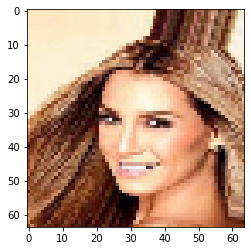

In [6]:
plt.imshow(img.numpy().astype("uint8"))

In [7]:
true_label = encoder(tf.expand_dims(img, axis=0), training=False)
recon_img = tf.Variable(tf.expand_dims(tf.random.normal(img.shape, 0, 1, tf.float32), axis=0), trainable=True)
print(img.shape, true_label.shape, recon_img.shape)

2023-04-15 18:16:34.938357: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


(64, 64, 3) (1, 16, 16, 64) (1, 64, 64, 3)


In [8]:
loss_object = tf.keras.losses.MeanSquaredError()
def loss(model, label, img_, training):
    y_ = model(img_, training=training)
    return loss_object(y_true=label, y_pred=y_)

l = loss(encoder, true_label, img_=recon_img, training=False)
print("Loss test: {}".format(l))

Loss test: 7.907196998596191


In [9]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, targets, inputs, training=False)
    return loss_value, tape.gradient(loss_value, inputs)

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [11]:
loss_value, grads = grad(encoder, recon_img, true_label)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip([grads], [recon_img]))
print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(encoder, true_label, recon_img, training=False).numpy()))

Step: 0, Initial Loss: 7.907196998596191
Step: 1,         Loss: 7.905546188354492


In [17]:
train_loss_results = []

num_epochs = 1000000

for epoch in range(num_epochs):
    loss_value, grads = grad(encoder, recon_img, true_label)
    optimizer.apply_gradients(zip([grads], [recon_img]))
    if epoch % 100000 == 0:
        print(f'epoch {epoch}, loss {loss_value}')

epoch 0, loss 5.677288055419922
epoch 100000, loss 0.10981334745883942


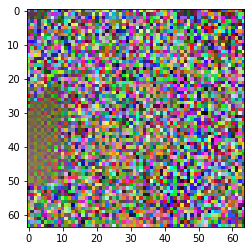

In [19]:
plt.imshow(np.squeeze(recon_img).astype("uint8"))
plt.savefig('clean.jpg')